In [575]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import string
import os

py_path = os.path.join(os.path.dirname(os.getcwd()),"markdown_predictions")
sys.path.insert(0,py_path)
from parse_data import LoadSalesData

# Load the data

In [576]:
JSON_PATH = os.path.join(os.path.dirname(os.getcwd()),"markdown_predictions")

In [577]:
loaded_data = LoadSalesData.load_in_files("../raw_data")
df = loaded_data.sales_data

In [578]:
df.head(5)

,delivery_PRE,window_display_PRE,target_PRE,gender_PRE,product_category_PRE,family_PRE,sub_family_PRE,macro_category_PRE,reference_name_PRE,reference_PRE,...,cum_quantity_sold_POST,num_sizes_POST,num_stores_POST,first_week_sale_POST,rate_of_sale_POST,cum_sellthrough_POST,warehouse_stock_POST,zero_stock_POST,avail_warehouse_stock_POST,%_POST
0,PERM SELECTIF EARLY SEASON,PERM S VET EARLY ADF_JOUR PERM,3-ADULTE,FE,JOUR,FA GROSSES PIECES VET,"CIRES, COUPE VENT VET",Adulte Jour,CIRE,5246101.0,...,"3,012",7,137,2019-S28,0.76,98 %,0,0,0,0%
1,PERM SELECTIF EARLY SEASON,PERM S VET EARLY ADF_JOUR PERM,3-ADULTE,FE,JOUR,FA GROSSES PIECES VET,"CIRES, COUPE VENT VET",Adulte Jour,CIRE,5246102.0,...,"2,930",7,136,2019-S28,0.74,99 %,0,0,0,0%
2,AH2019 SELECTIF PREVIEW,19 S VET N-SV_PARIS,2-ENFANT,FE,NUIT,FA PYJAMAS VET,SF PYJALONG,Enfant Nuit,COPARIS,5225401.0,...,"6,196",8,169,2019-S28,1.26,100 %,0,0,0,0%
3,AH2019 SELECTIF HIGH SEASON,19 S VET HIGH JRENF_ICED WINTE,2-ENFANT,FE,JOUR,FA ROBES VET,ROBES ML VET,Enfant Jour,CORAIL,4958901.0,...,"3,647",7,170,2019-S35,0.98,95 %,0,0,0,20%
4,AH2019 SELECTIF HIGH SEASON,19 S VET HIGH N-SV_FESTIVE SEA,2-ENFANT,MA,NUIT,FA PYJAMAS VET,SF PYJALONG,Enfant Nuit,CHATEAU,5105201.0,...,"3,248",8,169,2019-S43,1.01,86 %,0,0,0,20%


In [617]:
df.columns

Index(['delivery_PRE', 'window_display_PRE', 'target_PRE', 'gender_PRE',
       'product_category_PRE', 'family_PRE', 'sub_family_PRE',
       'macro_category_PRE', 'reference_name_PRE', 'reference_PRE',
       'description_PRE', 'color_PRE', 'material_PRE', 'seasonality_PRE',
       'price_PRE', 'weekly_rank_PRE', 'turnover_PRE', 'sub_target_PRE',
       'turnover_w_sub1_PRE', 'turnover_w_sub2_PRE', 'turnover_w_sub3_PRE',
       'quantity_sold_PRE', 'quantity_sold_sub1_PRE', 'quantity_sold_sub2_PRE',
       'quantity_sold_sub3_PRE', 'discount_rate_PRE', 'discount_rate_sub1_PRE',
       'store_stock_PRE', 'stock_transit_PRE', 'total_store_stock_PRE',
       'weekly_cover_PRE', 'cum_turnover_PRE', 'cum_discount_rate_PRE',
       'cum_quantity_sold_PRE', 'num_sizes_PRE', 'num_stores_PRE',
       'first_week_sale_PRE', 'rate_of_sale_PRE', 'cum_sellthrough_PRE',
       'warehouse_stock_PRE', 'zero_stock_PRE', 'avail_warehouse_stock_PRE',
       '%_PRE', 'season_PRE', 'reference_POST', 'sea

# Clean data

In [579]:
df.replace('-', np.nan, inplace=True)
df.dropna(inplace=True)

In [580]:
def replace_commas(x):
    x = x.replace(",",".")
    return x

def remove_commas(x):
    x = x.replace(",","")
    return x

def remove_symbols(x):
    symbols = ['€','%']
    for symbol in symbols:
        x = x.replace(symbol,"")
    return x

## Replace price commas with decimals & convert

In [581]:
df['price_PRE'] = df['price_PRE'].apply(replace_commas)
df['price_PRE'] = df['price_PRE'].astype(float)
df['price_POST'] = df['price_POST'].apply(replace_commas)
df['price_POST'] = df['price_POST'].astype(float)

## Remove commas, remove symbols, & convert numeric features

In [582]:
for col in df.columns:
    try:
        df[col] = df[col].apply(remove_commas)
        df[col] = df[col].apply(remove_symbols)
    except AttributeError:
        pass
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        print(f'leaving {col} as type string')

leaving delivery_PRE as type string
leaving window_display_PRE as type string
leaving target_PRE as type string
leaving gender_PRE as type string
leaving product_category_PRE as type string
leaving family_PRE as type string
leaving sub_family_PRE as type string
leaving macro_category_PRE as type string
leaving reference_name_PRE as type string
leaving reference_PRE as type string
leaving description_PRE as type string
leaving color_PRE as type string
leaving material_PRE as type string
leaving seasonality_PRE as type string
leaving sub_target_PRE as type string
leaving first_week_sale_PRE as type string
leaving season_PRE as type string
leaving reference_POST as type string
leaving seasonality_POST as type string
leaving first_week_sale_POST as type string


## Deal with week of first sale, convert to datetime

In [583]:
def remove_s(x):
    x = x.replace('S','')
    return x

def add_monday(x):
    x = x + 'Mon'
    return x

In [584]:
df['first_week_sale_POST'] = df['first_week_sale_POST'].apply(remove_s)
df['first_week_sale_PRE'] = df['first_week_sale_PRE'].apply(remove_s)
df['first_week_sale_POST'] = df['first_week_sale_POST'].apply(add_monday)
df['first_week_sale_PRE'] = df['first_week_sale_PRE'].apply(add_monday)

In [585]:
df['first_week_sale_PRE'] = pd.to_datetime(df['first_week_sale_PRE'],errors='coerce',format='%Y-%U%a')
df['first_week_sale_POST'] = pd.to_datetime(df['first_week_sale_POST'],errors='coerce',format='%Y-%U%a')

In [586]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6078 entries, 3 to 12926
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   delivery_PRE                6078 non-null   object        
 1   window_display_PRE          6078 non-null   object        
 2   target_PRE                  6078 non-null   object        
 3   gender_PRE                  6078 non-null   object        
 4   product_category_PRE        6078 non-null   object        
 5   family_PRE                  6078 non-null   object        
 6   sub_family_PRE              6078 non-null   object        
 7   macro_category_PRE          6078 non-null   object        
 8   reference_name_PRE          6078 non-null   object        
 9   reference_PRE               6078 non-null   object        
 10  description_PRE             6078 non-null   object        
 11  color_PRE                   6078 non-null   object     

# Correlations

In [587]:
df['sales_after_markdown'] = df['cum_quantity_sold_POST'] - df['cum_quantity_sold_PRE']

In [588]:
df.corr()

,price_PRE,weekly_rank_PRE,turnover_PRE,turnover_w_sub1_PRE,turnover_w_sub2_PRE,turnover_w_sub3_PRE,quantity_sold_PRE,quantity_sold_sub1_PRE,quantity_sold_sub2_PRE,quantity_sold_sub3_PRE,...,cum_quantity_sold_POST,num_sizes_POST,num_stores_POST,rate_of_sale_POST,cum_sellthrough_POST,warehouse_stock_POST,zero_stock_POST,avail_warehouse_stock_POST,%_POST,sales_after_markdown
price_PRE,1.000000,-0.207295,0.227817,0.194508,0.240243,0.209185,-0.109849,-0.097297,-0.077142,-0.077509,...,-0.165019,0.006569,-0.106617,-0.041266,-0.078640,-0.027175,NaN,-0.025406,0.191749,-0.115126
weekly_rank_PRE,-0.207295,1.000000,-0.756759,-0.603585,-0.579521,-0.528958,-0.724821,-0.541358,-0.504573,-0.473900,...,-0.605088,-0.226361,-0.535466,0.084605,-0.213531,-0.064845,NaN,-0.063867,0.062737,-0.596459
turnover_PRE,0.227817,-0.756759,1.000000,0.745543,0.654160,0.624610,0.841432,0.567387,0.456991,0.475455,...,0.520070,0.206217,0.364898,-0.045526,0.187414,0.039921,NaN,0.041593,-0.061406,0.504858
turnover_w_sub1_PRE,0.194508,-0.603585,0.745543,1.000000,0.814308,0.774613,0.603328,0.859036,0.645627,0.631006,...,0.457678,0.195460,0.311398,-0.034379,0.183933,-0.078023,NaN,-0.079718,-0.085030,0.351706
turnover_w_sub2_PRE,0.240243,-0.579521,0.654160,0.814308,1.000000,0.673758,0.525323,0.672821,0.851362,0.544984,...,0.487164,0.201966,0.316610,-0.037395,0.202589,-0.056869,NaN,-0.059078,-0.014946,0.365232
turnover_w_sub3_PRE,0.209185,-0.528958,0.624610,0.774613,0.673758,1.000000,0.500595,0.628813,0.502547,0.860962,...,0.469421,0.187085,0.304834,-0.040811,0.172194,-0.071756,NaN,-0.074323,-0.059753,0.329448
quantity_sold_PRE,-0.109849,-0.724821,0.841432,0.603328,0.525323,0.500595,1.000000,0.656171,0.544470,0.547679,...,0.663981,0.223758,0.428308,-0.045707,0.226859,0.047820,NaN,0.048945,-0.140086,0.605032
quantity_sold_sub1_PRE,-0.097297,-0.541358,0.567387,0.859036,0.672821,0.628813,0.656171,1.000000,0.746030,0.697271,...,0.562203,0.219787,0.342717,-0.034007,0.206247,-0.093696,NaN,-0.096797,-0.156550,0.424036
quantity_sold_sub2_PRE,-0.077142,-0.504573,0.456991,0.645627,0.851362,0.502547,0.544470,0.746030,1.000000,0.581786,...,0.585713,0.214235,0.348680,-0.033875,0.226761,-0.058224,NaN,-0.062470,-0.073228,0.440375
quantity_sold_sub3_PRE,-0.077509,-0.473900,0.475455,0.631006,0.544984,0.860962,0.547679,0.697271,0.581786,1.000000,...,0.586406,0.192225,0.350509,-0.032043,0.198155,-0.065453,NaN,-0.069954,-0.115610,0.401731


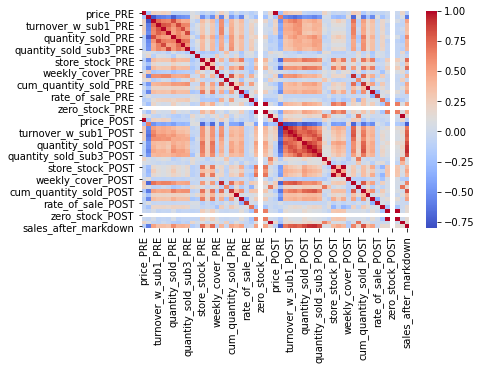

In [589]:
sns.heatmap(df.corr(), cmap='coolwarm');

## Split into PRE & POST

In [590]:
pre_columns = []
post_columns = []
for col in df.columns:
    if col[-1] == 'E':
        pre_columns.append(col)
    if col[-1] == 'T':
        post_columns.append(col)

In [591]:
pre_df = df[pre_columns]
post_df = df[post_columns]

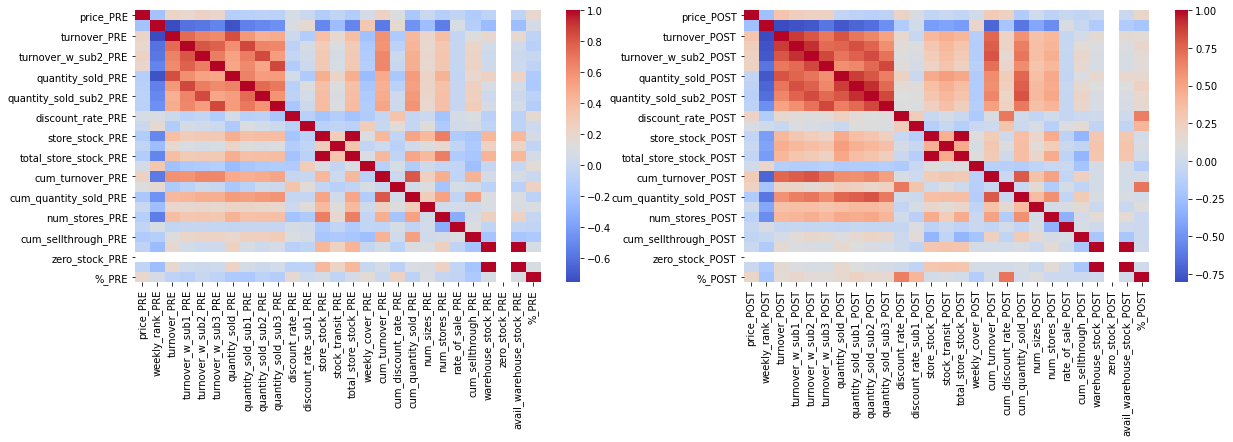

In [619]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.heatmap(pre_df.corr(), cmap='coolwarm')

plt.subplot(1,2,2)
sns.heatmap(post_df.corr(), cmap='coolwarm');

<AxesSubplot:xlabel='discount_rate_PRE', ylabel='%_PRE'>

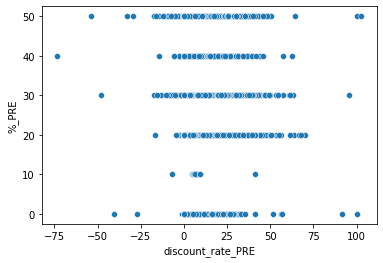

In [593]:
sns.scatterplot(x=df['discount_rate_PRE'],y=df['%_PRE'])

(-5.0, 52.60995545401121)

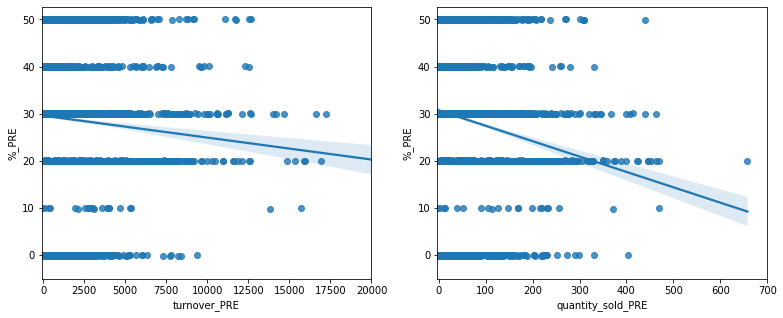

In [594]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['turnover_PRE'], y = df['%_PRE'], y_jitter=.1)
plt.xlim(right=20_000)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['quantity_sold_PRE'], y= df['%_PRE'], y_jitter=.1)
plt.xlim(right=700)
plt.ylim(bottom=-5)

(-5.0, 55.43530736574772)

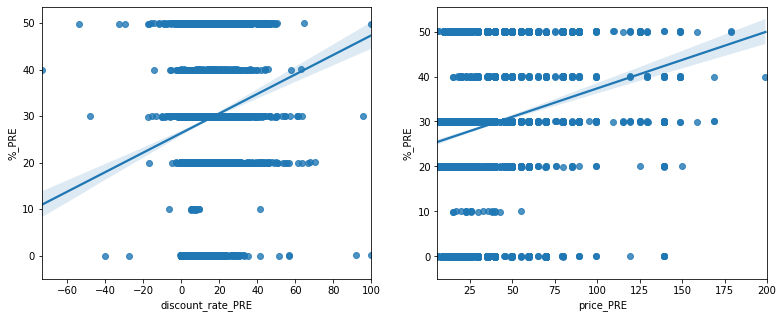

In [595]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['discount_rate_PRE'], y = df['%_PRE'], y_jitter=.1)
plt.xlim(right=100)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['price_PRE'], y= df['%_PRE'], y_jitter=.1)
plt.xlim(right=200)
plt.ylim(bottom=-5)

# Statsmodels

In [596]:
import statsmodels.formula.api as smf

In [597]:
def compute_rmse(pred,actual):
    diff = pred - actual
    rmse = (((diff) ** 2 / len(diff)) ** 0.5).mean()
    return rmse

## Markdown

In [598]:
df['markdown_PRE'] = df['%_PRE']
df['markdown_POST'] = df['%_POST']

In [599]:
model1 = smf.ols(formula = 'markdown_PRE ~ discount_rate_PRE + price_PRE', data = df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           markdown_PRE   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     203.2
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           3.89e-86
Time:                        15:43:23   Log-Likelihood:                -24450.
No. Observations:                6078   AIC:                         4.891e+04
Df Residuals:                    6075   BIC:                         4.893e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6945      0.357     63.487      0.000      21.994      23.395
discount_rate_PRE     0.1934      0.015     12.963      0.000       0.164       0.223
price_PRE             0.1182      0.008     14.364      0.000       0.102       0.134
==============================================================================
Omnibus:                       44.188   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.032
Skew:                          -0.211   Prob(JB):                     1.66e-10
Kurtosis:                       3.006   Cond. No.                         84.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [600]:
markdown_pred1 = model1.predict()

In [601]:
model2 = smf.ols(formula = 'markdown_PRE ~ turnover_PRE + gender_PRE', data = df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           markdown_PRE   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     97.32
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           1.59e-61
Time:                        15:43:23   Log-Likelihood:                -24504.
No. Observations:                6078   AIC:                         4.902e+04
Df Residuals:                    6074   BIC:                         4.904e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           31.7527      0.330     96.212      0.000      31.106      32.400
gender_PRE[T.MA]     1.0121      0.443      2.283      0.022       0.143       1.881
gender_PRE[T.MI]    -5.6518      0.414    -13.660      0.000      -6.463      -4.841
turnover_PRE        -0.0008   9.67e-05     -7.792      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       53.563   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.319
Skew:                          -0.223   Prob(JB):                     1.60e-12
Kurtosis:                       2.878   Cond. No.                     7.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [602]:
markdown_pred2 = model2.predict()

In [603]:
model3 = smf.ols(formula = 'markdown_PRE ~ first_week_sale_PRE', data = df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           markdown_PRE   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     6.931
Date:                Sat, 21 Aug 2021   Prob (F-statistic):          1.85e-116
Time:                        15:43:23   Log-Likelihood:                -24171.
No. Observations:                6078   AIC:                         4.863e+04
Df Residuals:                    5932   BIC:                         4.961e+04
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  40.0000      6.533      6.123      0.000      27.192      52.808
first_week_sale_PRE[T.Timestamp('2017-12-18 00:00:00')] -1.218e-13      8.190  -1.49e-14      1.000     -16.055      16.055
first_week_sale_PRE[T.Timestamp('2017-12-25 00:00:00')]    -8.3333      8.434     -0.988      0.323     -24.868       8.201
first_week_sale_PRE[T.Timestamp('2018-01-08 00:00:00')]     0.4545      6.728      0.068      0.946     -12.735      13.645
first_week_sale_PRE[T.Timestamp('2018-01-15 00:00:00')]     3.3333      7.852      0.425      0.671     -12.059      18.726
first_week_sale_PRE[T.Timestamp('2018-01-22 00:00:00')]    -0.2000      6.790     -0.029      0.977     -13.510      13.110
first_week_sale_PRE[T.Timestamp('2018-01-29 00:00:00')]   -12.7632      6.703     -1.904      0.057     -25.903       0.377
first_week_sale_PRE[T.Timestamp('2018-02-05 00:00:00')]    -5.4839      6.741     -0.814      0.416     -18.698       7.730
first_week_sale_PRE[T.Timestamp('2018-02-12 00:00:00')]    -9.7260      6.710     -1.450      0.147     -22.880       3.428
first_week_sale_PRE[T.Timestamp('2018-02-19 00:00:00')]    -8.4615      6.731     -1.257      0.209     -21.657       4.734
first_week_sale_PRE[T.Timestamp('2018-02-26 00:00:00')]    -0.3704      7.001     -0.053      0.958     -14.094      13.353
first_week_sale_PRE[T.Timestamp('2018-03-05 00:00:00')]   -14.0000      6.955     -2.013      0.044     -27.635      -0.365
first_week_sale_PRE[T.Timestamp('2018-03-12 00:00:00')]   -10.0000      7.852     -1.274      0.203     -25.393       5.393
first_week_sale_PRE[T.Timestamp('2018-03-19 00:00:00')]   -19.5833      7.057     -2.775      0.006     -33.417      -5.750
first_week_sale_PRE[T.Timestamp('2018-03-26 00:00:00')]   -12.9114      6.697     -1.928      0.054     -26.039       0.216
first_week_sale_PRE[T.Timestamp('2018-04-02 00:00:00')]   -16.0000      6.790     -2.357      0.018     -29.310      -2.690
first_week_sale_PRE[T.Timestamp('2018-04-09 00:00:00')]   -16.4865      6.877     -2.397      0.017     -29.969      -3.004
first_week_sale_PRE[T.Timestamp('2018-04-16 00:00:00')]   -15.2941      7.261     -2.106      0.035     -29.529      -1.059
first_week_sale_PRE[T.Timestamp('2018-04-23 00:00:00')]   -13.4375      6.930     -1.939      0.053     -27.022       0.147
first_week_sale_PRE[T.Timestamp('2018-04-30 00:00:00')]   -40.0000     14.609     -2.738      0.006     -68.639     -11.361
first_week_sale_PRE[T.Timestamp('2018-05-07 00:00:00')]   -35.0000      9.239     -3.788      0.000     -53.113     -16.887
first_week_sale_PRE[T.Timestamp('2018-05-21 00:00:00')]   -23.3333      9.980     -2.338      0.019     -42

In [604]:
markdown_pred3 = model3.predict()

### Markdown baseline compare

RMSE may not be the best metric for predicting this, as markdowns fall into one of 6 options (0, 10, 20, 30, 40, 50). The target seems categorical, but categories are also ranked.  

In [605]:
df['markdown_PRE'].mean()

28.89437314906219

In [606]:
markdown_baseline = compute_rmse(df['markdown_PRE'].mean(),df['markdown_PRE'])
markdown_baseline

0.13219443388517743

In [607]:
md_rmse1 = compute_rmse(markdown_pred1,df['markdown_PRE'])
md_rmse1

0.13138814586350958

In [608]:
md_rmse2 = compute_rmse(markdown_pred2,df['markdown_PRE'])
md_rmse2

0.13380484805372186

In [609]:
md_rmse3 = compute_rmse(markdown_pred3,df['markdown_PRE'])
md_rmse3

0.12780542064758688

## Sales

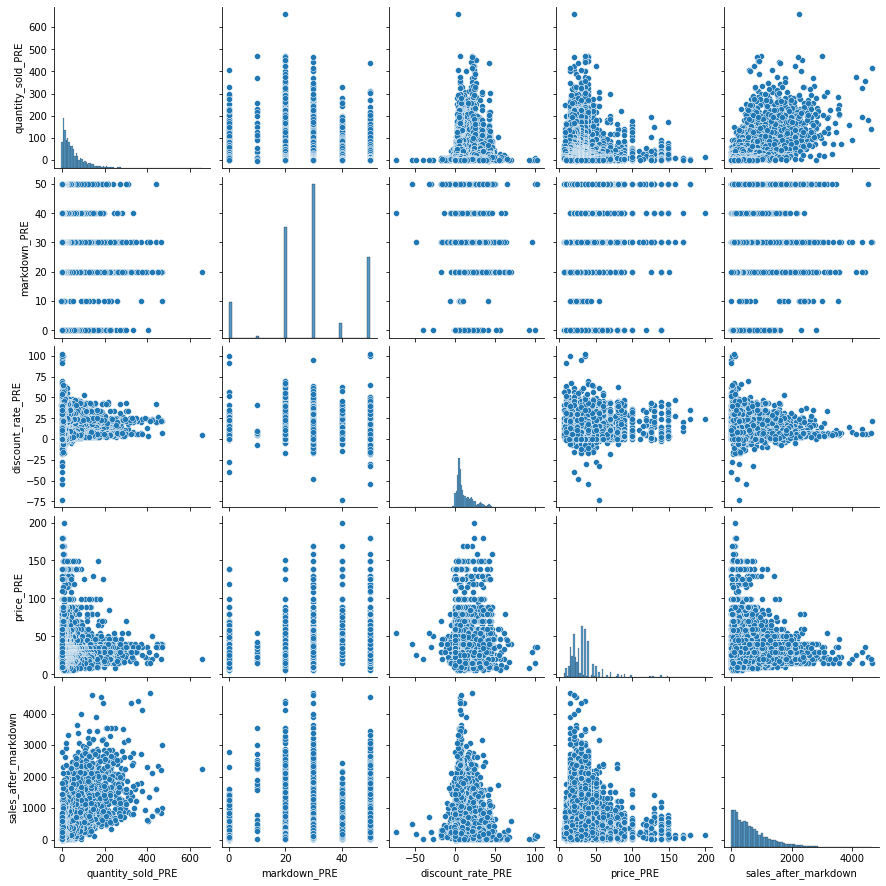

In [610]:
sns.pairplot(df[['first_week_sale_PRE','quantity_sold_PRE','markdown_PRE','discount_rate_PRE','price_PRE','sales_after_markdown']])

(-100.0, 4887.85)

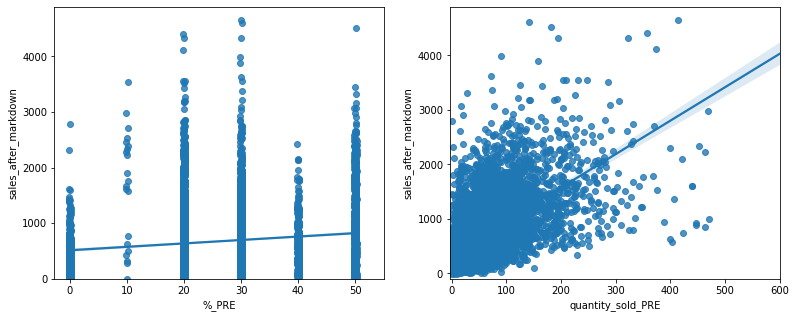

In [611]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['%_PRE'], y = df['sales_after_markdown'], x_jitter=.2)
plt.xlim(right=55)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['quantity_sold_PRE'], y= df['sales_after_markdown'])
plt.xlim(right=600)
plt.ylim(bottom=-100)

(-100.0, 4895.137701567831)

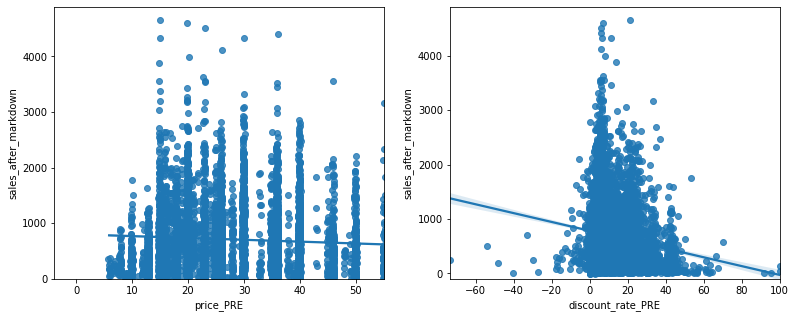

In [612]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['price_PRE'], y = df['sales_after_markdown'], x_jitter=.2)
plt.xlim(right=55)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['discount_rate_PRE'], y= df['sales_after_markdown'])
plt.xlim(right=100)
plt.ylim(bottom=-100)

In [613]:
sales_model = smf.ols(formula = 'sales_after_markdown ~ quantity_sold_PRE + markdown_PRE + gender_PRE + weekly_cover_PRE + product_category_PRE', data = df).fit()
sales_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     sales_after_markdown   R-squared:                       0.456
Model:                              OLS   Adj. R-squared:                  0.455
Method:                   Least Squares   F-statistic:                     508.1
Date:                  Sat, 21 Aug 2021   Prob (F-statistic):               0.00
Time:                          15:43:40   Log-Likelihood:                -45748.
No. Observations:                  6078   AIC:                         9.152e+04
Df Residuals:                      6067   BIC:                         9.159e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -68.7420     24.329     -2.825      0.005    -116.436     -21.048
gender_PRE[T.MA]                       109.4578     14.938      7.328      0.000      80.174     138.741
gender_PRE[T.MI]                       -67.7702     15.721     -4.311      0.000     -98.589     -36.951
product_category_PRE[T.AISV]           128.1444     27.765      4.615      0.000      73.714     182.574
product_category_PRE[T.JOUR]           172.5579     22.163      7.786      0.000     129.110     216.006
product_category_PRE[T.NUIT]           174.9885     21.502      8.138      0.000     132.838     217.139
product_category_PRE[T.PUERICULTURE]    39.4807     46.027      0.858      0.391     -50.749     129.710
product_category_PRE[T.SS VET]         299.2985     24.579     12.177      0.000     251.115     347.482
quantity_sold_PRE                        6.1767      0.102     60.766      0.000       5.977       6.376
markdown_PRE                             8.4854      0.458     18.532      0.000       7.588       9.383
weekly_cover_PRE                         0.0777      0.052      1.504      0.133      -0.024       0.179
==============================================================================
Omnibus:                     1413.096   Durbin-Watson:                   1.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6553.245
Skew:                           1.054   Prob(JB):                         0.00
Kurtosis:                       7.630   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Sales baseline compare

In [614]:
y_baseline = df['sales_after_markdown'].mean()
y_pred = sales_model.predict()

In [615]:
compute_rmse(y_pred,df['sales_after_markdown'])

4.078117796544979

In [616]:
compute_rmse(y_baseline,df['sales_after_markdown'])

5.982422457504408